In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import glob

import datetime as dt
import numpy as np
import random

import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow.keras.backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.image import grayscale_to_rgb

from functools import partial

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

In [2]:
params = {
    "data_dir": "/media/pipeh/Data/Datasets/vkitti/", #"D:/Datasets/vkitti/"
    "checkpoint_path": "model/vkitti_depth_v5",
    "model_path": "model/vkitti_depth_v5.h5",
    "lr": 0.0001,
    "batch_size": 64,
    "epochs": 100,
    "img_height": 48,
    "img_width": 48,
    "crop_size": 240
}

In [3]:
def get_files(params):
    #https://europe.naverlabs.com/research/computer-vision/proxy-virtual-worlds-vkitti-2/
    img_files = glob.glob(params['data_dir']+'vkitti_2.0.3_rgb/*/*/frames/rgb/Camera_0/*.jpg')
    seg_files = glob.glob(params['data_dir']+'vkitti_2.0.3_depth/*/*/frames/depth/Camera_0/*.png')
    img_files.sort()
    seg_files.sort()
    test_files = []
    train_files = []
    for i in range(len(img_files)):
        if 'Scene20' in img_files[i]:
            test_files.append(( img_files[i], seg_files[i] ))
        else:
            train_files.append(( img_files[i], seg_files[i] ))      
    return train_files, test_files 

In [4]:
def read_images(img_path, disparity_path):
    img_data = tf.io.read_file(img_path)
    img = tf.io.decode_jpeg(img_data)
    dis_data = tf.io.read_file(disparity_path)
    dis = tf.io.decode_png(dis_data)
    return img, dis

In [5]:
def data_augmentation_train(image, target):
    transform = A.Compose([
            A.CenterCrop (height=params['crop_size'], width=params['crop_size'], p=1.0),  
            A.Resize (height=params['img_height'], width=params['img_width'], interpolation=3),
            #A.CoarseDropout (max_holes=1, max_height=8, max_width=8, p=1.0),
            #A.ShiftScaleRotate (shift_limit=0.02, scale_limit=0.02, rotate_limit=15, p=1.0),
            #A.ColorJitter (p=1.0),
            #A.HorizontalFlip (p=0.5),
            #A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
            #A.RandomBrightnessContrast (brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, p=0.5),
            #A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ])
    data = {"image": np.array(image,dtype='float32')*(1/127.5) -1}
    aug_data = transform(**data)
    image = aug_data["image"]
    data = {"image": np.array(target,dtype='float32')*(1/127.5) -1}    
    aug_data = transform(**data)
    target = aug_data["image"]
    image = tf.cast(image, tf.float32)
    target = tf.cast(target, tf.float32)
    return image, target

In [6]:
def data_augmentation_test(image, target):
    transform = A.Compose([
            A.CenterCrop (height=params['crop_size'], width=params['crop_size'], p=1.0),
            A.Resize (height=params['img_height'], width=params['img_width']),
            #A.Normalize (mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=1.0),
        ])
    data = {"image": np.array(image,dtype='float32')*(1/127.5) -1}
    aug_data = transform(**data)
    image = aug_data["image"]
    data = {"image": np.array(target,dtype='float32')*(1/127.5) -1}    
    aug_data = transform(**data)
    target = aug_data["image"]
    image = tf.cast(image, tf.float32)
    target = tf.cast(target, tf.float32)
    return image, target

In [7]:
def process_data_train(image, target):
    (image, target) = tf.numpy_function(func=data_augmentation_train, inp=[image, target], Tout=(tf.float32, tf.float32))
    return image, target

In [8]:
def process_data_test(image, target):
    (image, target) = tf.numpy_function(func=data_augmentation_test, inp=[image, target], Tout=(tf.float32, tf.float32))
    return image, target

In [9]:
train_files, test_files = get_files(params)
random.shuffle(train_files)
random.shuffle(test_files)

In [10]:
rgb, depth = zip(*train_files)
ds_train = tf.data.Dataset.from_tensor_slices((list(rgb), list(depth)))
rgb, depth = zip(*test_files)
ds_test = tf.data.Dataset.from_tensor_slices((list(rgb), list(depth)))

In [11]:
ds_train = ( ds_train
            .map(read_images, num_parallel_calls=tf.data.AUTOTUNE)
            .map(partial(process_data_train), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            .shuffle(13000, reshuffle_each_iteration=True)
            .batch(params["batch_size"])
            .prefetch(tf.data.AUTOTUNE)
           )

In [12]:
ds_test = ( ds_test
            .map(read_images, num_parallel_calls=tf.data.AUTOTUNE)
            .map(partial(process_data_test), num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            .batch(params["batch_size"])
            .prefetch(tf.data.AUTOTUNE)
           )

In [13]:
def view_image(ds, samples=5):
    image, target = next(iter(ds))
    image += 1.
    image *= 0.5
    target += 1.
    target *= 0.5
    print(f"image.shape {image.shape}")
    print(f"target.shape {target.shape}")
    
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(5, 12))
    for i in range(samples):
        ax[i, 0].imshow(image[i])
        ax[i, 1].imshow(target[i])
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented depth")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
train_files[

In [ ]:
import cv2


depth = cv2.imread(depth_png_filename, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)

image.shape (64, 48, 48, 3)
target.shape (64, 48, 48, 1)


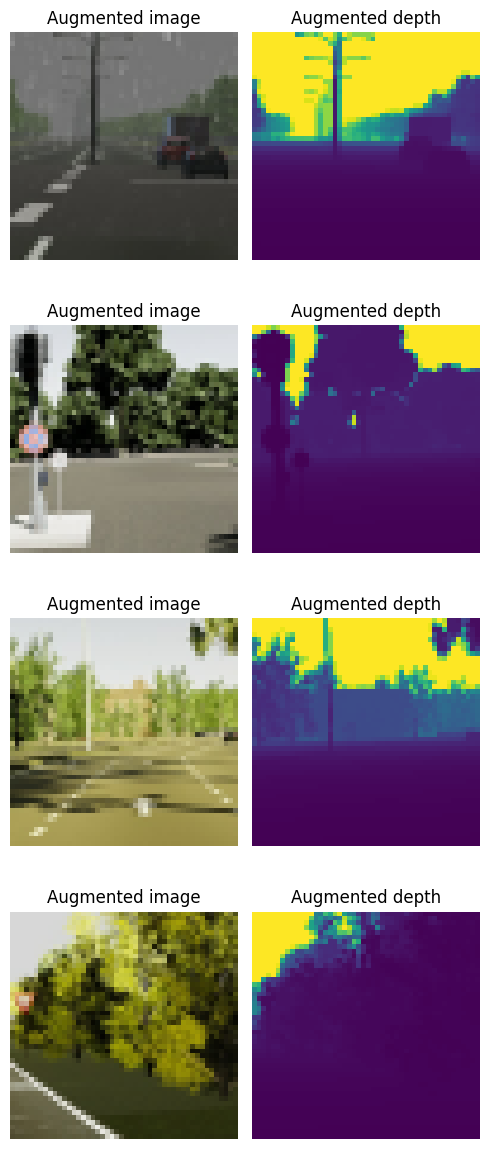

In [14]:
view_image(ds_train, samples=4)

In [13]:
def FPN(params):

    # ======================================== INPUT ==========================================
    xin = tf.keras.layers.Input(shape=[params['img_height'], params['img_width'], 3], dtype=tf.float32)

    # =================================== SHALLOW ENCODER =====================================
    # first level
    x1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(xin)
    x2 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu')(x1)

    # second level
    x3 = tf.keras.layers.Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu')(x2)
    x4 = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(x3)

    # third level
    x5 = tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(x4)
    #x6 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x5)

    # ====================================== DECODER =======================================
    # first level
    x7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x5)
    #x8 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x7)    
    x9 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x7)
    x10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x9)
    dec1 = tf.keras.layers.concatenate([x10, x4])
    
    # second level
    x11 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(dec1)
    #x12 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x11)
    x13 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x11)
    x14 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x13)
    dec2 = tf.keras.layers.concatenate([x14, x2])
    
    # third level
    x15 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(dec2)
    #x16 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x15)
    x17 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x15)

    # ======================================== OUTPUT ==========================================
    outconv = tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='tanh')(x17)

    return tf.keras.Model(inputs=xin, outputs=outconv)

In [16]:
model = FPN(params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 8)    224         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 48, 48, 8)    584         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 24, 24, 16)   1168        ['conv2d_1[0][0]']               
                                                                                              

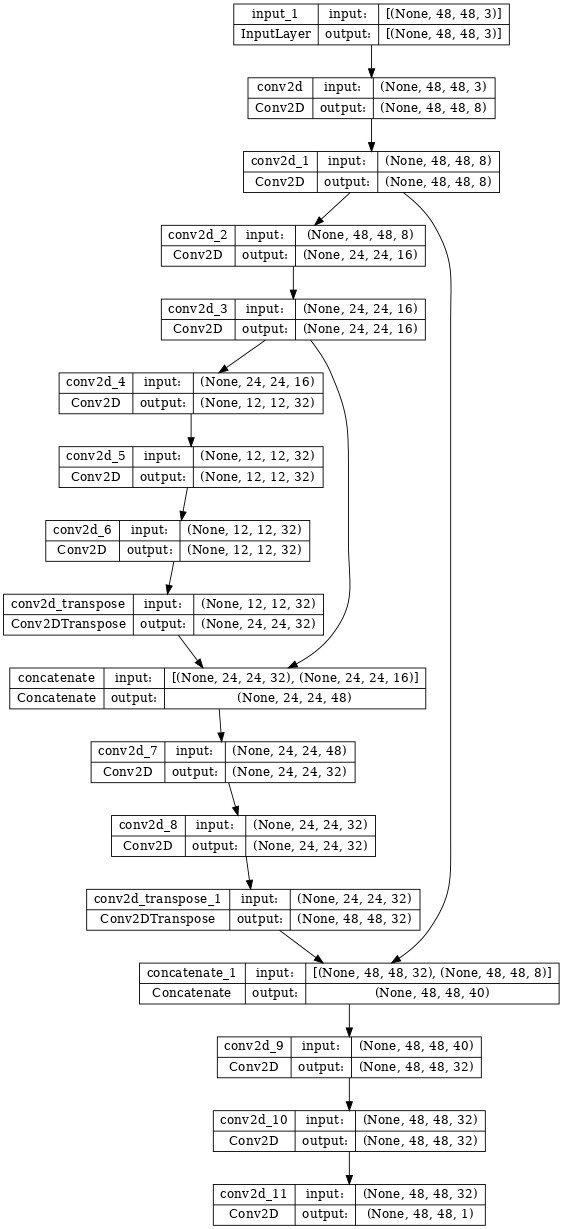

In [17]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [18]:
def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred))

In [19]:
def bce_loss(y_true, y_pred):
    y_true = (y_true + 1) / 2.0  # Rescale y_true to [0, 1]
    y_pred = (y_pred + 1) / 2.0  # Rescale y_pred to [0, 1]
    bce = K.mean(K.binary_crossentropy(y_true, y_pred))
    return bce

In [20]:
vgg = VGG16(include_top=False, weights='imagenet')
loss_model = tf.keras.Model(inputs=vgg.input, outputs=vgg.get_layer('block4_conv3').output)
loss_model.trainable = False

def perceptual_loss(y_true, y_pred):
    y_true = tf.image.grayscale_to_rgb(y_true)
    y_pred = tf.image.grayscale_to_rgb(y_pred)
    true_features = loss_model(y_true, training=False)
    pred_features = loss_model(y_pred, training=False)
    return K.mean(K.square(true_features - pred_features))

In [21]:
def custom_loss(y_true, y_pred):
    alfa = 0.5
    beta1 = 0.1
    beta2 = 0.4
    mse = mse_loss(y_true, y_pred)
    bce = bce_loss(y_true, y_pred)
    perceptual = perceptual_loss(y_true, y_pred)
    total_loss = alfa*mse + beta1*bce + beta2*perceptual
    return total_loss

In [22]:
def psnr_metric(y_true, y_pred):
    max_pixel = 2.0  # The maximum pixel value is 2.0 when normalized between -1 and 1
    mse = K.mean(K.square(y_true - y_pred))
    psnr = 20 * K.log(max_pixel / K.sqrt(mse)) / K.log(10.0)
    return psnr

In [23]:
def ssim_metric(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=2.0)

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=params["model_path"],
    save_weights_only=True,
    monitor='psnr_metric',# psnr_metric #https://videoprocessing.ai/metrics/ways-of-cheating-on-popular-objective-metrics.html
    mode='max',
    save_best_only=True,
    save_freq="epoch"
)

In [25]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=params["lr"]),
    loss=custom_loss,
    metrics=[psnr_metric, ssim_metric],
    #names=['psnr_metric','bce_metric']
)

In [26]:
model.fit(
    ds_train,
    epochs=params["epochs"],
    validation_data=ds_test,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/100
202/202 [==============================] - 95s 195ms/step - loss: 1.3136 - psnr_metric: 10.6289 - ssim_metric: 0.4102 - val_loss: 1.0344 - val_psnr_metric: 11.6152 - val_ssim_metric: 0.5419
Epoch 2/100
202/202 [==============================] - 104s 179ms/step - loss: 0.6940 - psnr_metric: 15.0057 - ssim_metric: 0.6491 - val_loss: 0.8150 - val_psnr_metric: 14.1434 - val_ssim_metric: 0.6322
Epoch 3/100
202/202 [==============================] - 80s 178ms/step - loss: 0.5461 - psnr_metric: 16.9066 - ssim_metric: 0.7044 - val_loss: 0.7457 - val_psnr_metric: 15.0523 - val_ssim_metric: 0.6721
Epoch 4/100
202/202 [==============================] - 77s 167ms/step - loss: 0.4813 - psnr_metric: 17.7665 - ssim_metric: 0.7335 - val_loss: 0.7163 - val_psnr_metric: 15.6340 - val_ssim_metric: 0.6873
Epoch 5/100
202/202 [==============================] - 102s 167ms/step - loss: 0.4408 - psnr_metric: 18.4253 - ssim_metric: 0.7537 - val_loss: 0.6764 - val_psnr_metric: 16.3815 - val_ssim_met

## Se prueba el modelo

In [27]:
model = FPN(params)
model.load_weights(params["model_path"])

In [28]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=params["lr"]),
    loss=custom_loss,
    metrics=[psnr_metric, ssim_metric],
)

In [29]:
score = model.evaluate(ds_test, verbose=0)

In [31]:
print('val_loss:', score[0])
print('val_psnr_metric:', score[1])
print('val_ssim_metric:', score[2])

val_loss: 0.5413720607757568
val_psnr_metric: 18.751235961914062
val_ssim_metric: 0.7724630236625671


In [32]:
def view_predictions(model, ds, samples=5):

    image, target = next(iter(ds))
    outputs = model(image, training=False)
    
    image += 1.
    image *= 0.5
    target += 1.
    target *= 0.5
    outputs += 1.
    outputs *= 0.5
    
    print(f"image.shape {image.shape}")
    print(f"target.shape {target.shape}")
    print(f"outputs.shape {outputs.shape}")
    
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(5, 12))
    for i in range(samples):
        ax[i, 0].imshow(image[i])
        ax[i, 1].imshow(target[i])
        ax[i, 2].imshow(outputs[i])
        ax[i, 0].set_title("image")
        ax[i, 1].set_title("target depth")
        ax[i, 2].set_title("predicted depth")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

image.shape (64, 48, 48, 3)
target.shape (64, 48, 48, 1)
outputs.shape (64, 48, 48, 1)


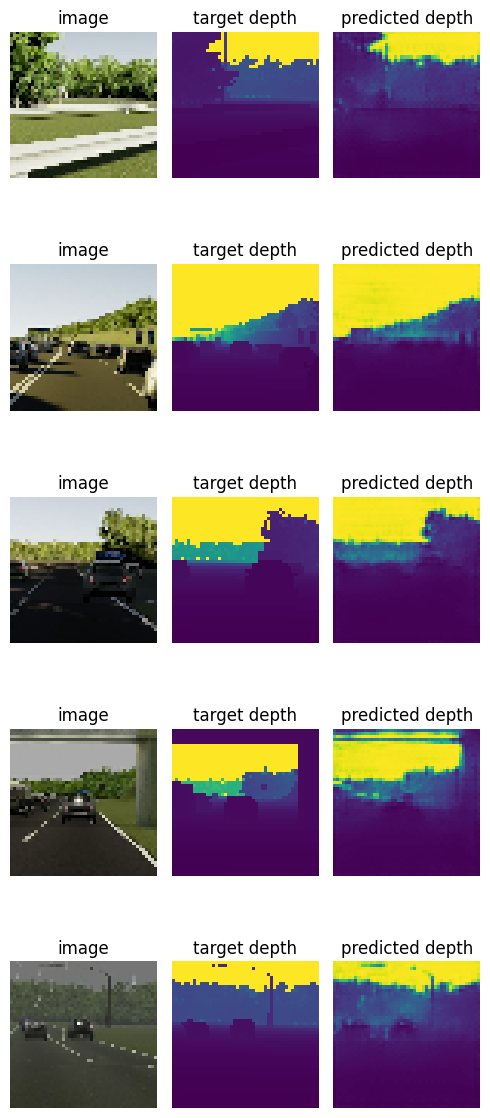

In [33]:
view_predictions(model, ds_test)

## Se crea el modelo final para el microcontrolador

In [14]:
def in_uc_preprocess(inputs):
    res_imgs = tf.image.resize(inputs, [48,48], method='nearest')
    norm_imgs = res_imgs*(1/127.5)-1
    return norm_imgs
def out_uc_preprocess(inputs):
    depth = (inputs+1)*127.5
    return depth

In [15]:
params["model_path"]

'model/vkitti_depth_v5.h5'

In [16]:
trained_model = FPN(params)
trained_model.load_weights(params["model_path"])

uc_final_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((240, 240, 3), dtype=tf.float32, name='image'),
    tf.keras.layers.Lambda(in_uc_preprocess),
    trained_model,
    tf.keras.layers.Lambda(out_uc_preprocess, name='depth'),
])

In [17]:
uc_final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 48, 48, 3)         0         
                                                                 
 model (Functional)          (None, 48, 48, 1)         79625     
                                                                 
 depth (Lambda)              (None, 48, 48, 1)         0         
                                                                 
Total params: 79,625
Trainable params: 79,625
Non-trainable params: 0
_________________________________________________________________


In [18]:
params["checkpoint_path"]

'model/vkitti_depth_v5'

In [19]:
uc_final_model.save(params["checkpoint_path"])

INFO:tensorflow:Assets written to: model/vkitti_depth_v5/assets


INFO:tensorflow:Assets written to: model/vkitti_depth_v5/assets


## Se testea el modelo del microcontrolador

In [20]:
uc_final_model = tf.keras.models.load_model(params["checkpoint_path"])
uc_final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 48, 48, 3)         0         
                                                                 
 model (Functional)          (None, 48, 48, 1)         79625     
                                                                 
 depth (Lambda)              (None, 48, 48, 1)         0         
                                                                 
Total params: 79,625
Trainable params: 79,625
Non-trainable params: 0
_________________________________________________________________


In [21]:
def view_micro_predictions(model, ds, samples=5):
    
    image, target = next(iter(ds))
    
    image += 1
    image *= 127.5
    image = tf.image.resize(image, [240,240], method='bilinear') 
    outputs = model(image, training=False)
    
    image = image / 255.
    target += 1.
    target *= 0.5
    print(f"image.shape {image.shape}")
    print(f"target.shape {target.shape}")
    print(f"outputs.shape {outputs.shape}")
    
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(5, 12))
    for i in range(samples):
        ax[i, 0].imshow(image[i])
        ax[i, 1].imshow(target[i])
        ax[i, 2].imshow(outputs[i])
        ax[i, 0].set_title("image")
        ax[i, 1].set_title("target depth")
        ax[i, 2].set_title("predicted depth")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
        ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

image.shape (64, 240, 240, 3)
target.shape (64, 48, 48, 1)
outputs.shape (64, 48, 48, 1)


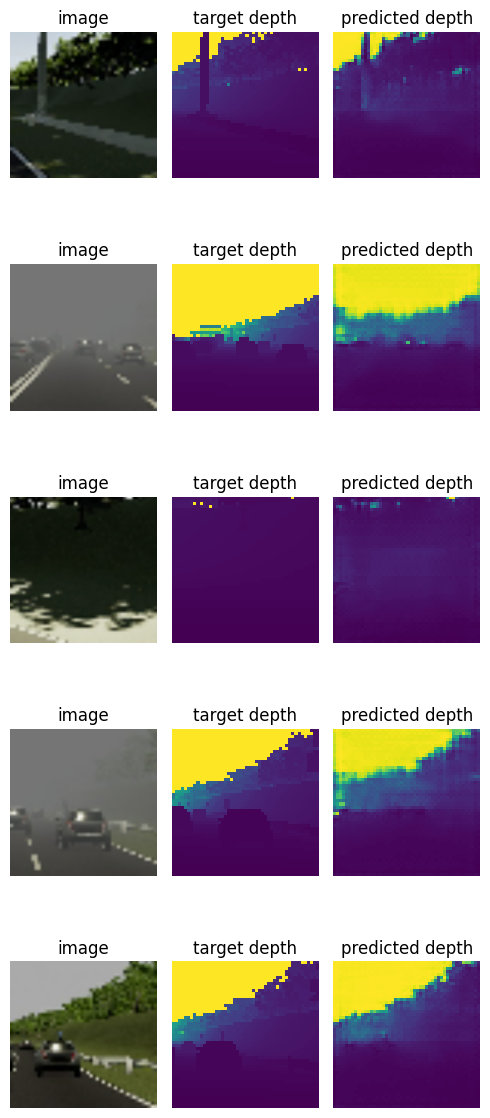

In [22]:
view_micro_predictions(uc_final_model, ds_test)

## Se serializa el modelo del microcontrolador

In [23]:
_, test_files = get_files(params)
rgb, depth = zip(*test_files)
ds_test = tf.data.Dataset.from_tensor_slices((list(rgb), list(depth)))

def process_representative(image, depth):
    image = tf.image.resize(image, [240,240], method='nearest') 
    depth = tf.image.resize(depth, [48,48], method='nearest') 
    image = tf.cast(image, tf.float32)
    depth = tf.cast(depth, tf.float32)
    return image, depth

ds_representative = ( ds_test
            .map(read_images, num_parallel_calls=tf.data.AUTOTUNE)
            .map(process_representative, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(1)
            .prefetch(tf.data.AUTOTUNE)
           )

In [24]:
def representative_dataset():
    for img, depth in ds_representative:
        yield {
          "image": img,
          "depth": depth,
        }

In [26]:
converter = tf.lite.TFLiteConverter.from_saved_model(params["checkpoint_path"])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8
tflite_quant_model = converter.convert()

fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


In [27]:
with open(params["checkpoint_path"]+".tflite", 'wb') as f:
    f.write(tflite_quant_model)

In [ ]:
!xxd -i vkitti_detpth.tflite > vkitti_depth.h

In [ ]:
# OPENMV para programar el portenta micropython

# https://eloquentarduino.com/esp32-cam-image-recognition/
# https://www.tensorflow.org/lite/microcontrollers/build_convert
# https://www.tensorflow.org/lite/microcontrollers#limitations

#https://stackoverflow.com/questions/64264509/esp32-cam-read-and-process-image
#

#https://github.com/PHANzgz/embedded-deep-learning/tree/master/applications/person_detection/application/nucleo-h743-person-car-detection

#https://stackoverflow.com/questions/74357954/is-there-documentation-for-tflitetensor-available

#https://stackoverflow.com/questions/74357954/is-there-documentation-for-tflitetensor-available

#https://github.com/tensorflow/tensorflow/tree/master/tensorflow/lite/c

#https://www.tensorflow.org/lite/guide/inference

#https://www.tensorflow.org/install/lang_c#example_program

#https://stackoverflow.com/questions/71525641/how-to-build-tensorflow-lite-c-api-static-library

# https://towardsdatascience.com/tensorflow-meet-the-esp32-3ac36d7f32c7
# https://stackoverflow.com/questions/71719891/compile-errors-in-tensorflow-lite-micro-framework-when-trying-to-integrate-tenso

# https://github.com/espressif/tflite-micro-esp-examples/blob/master/examples/person_detection/main/main_functions.cc#L68
# https://github.com/espressif/tflite-micro-esp-examples/issues/3


# Hybrid models are not supported on TFLite Micro.  Node CONV_2D (number 7) failed to invoke with status 1

In [ ]:

def save_model(model, path_stored_model, model_name):

     json_string = model.to_json()

     if not os.path.exists(path_stored_model):
       os.makedirs(path_stored_model)

     f = open(path_stored_model + model_name + '.jason', 'w')
     f.write(json_string)

     # 
self.model.save_weights('Deep_Learning/Deep_Model/Face_model_weights.h5')
     model.save(path_stored_model + 'model_' + model_name + '.h5')

     # serialize model to JSON
     model_json = model.to_json()
     with open(path_stored_model + 'model_' + model_name + ".json", 
"w") as json_file:
         json_file.write(model_json)

     with open(path_stored_model + 'model_' + model_name +  ".h", 'w') as f:
         f.write(port(model, optimize=False))
     print("Created model .h")

     # Convert the model to the TensorFlow Lite format without quantization
     converter = tf.lite.TFLiteConverter.from_keras_model(model)
     tflite_model = converter.convert()
     # Save the model to diskvalidation_split
     open(path_stored_model + 'model_' + model_name + ".tflite", 
"wb").write(tflite_model)

     # Optimized Model
     converter = tf.lite.TFLiteConverter.from_keras_model(model)
     optimizers = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
     converter.optimizations = optimizers
     tflite_model = converter.convert()
     open(path_stored_model + 'model_' + model_name + '_optimized' + 
".tflite", "wb").write(tflite_model)